For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/overview                                                       
dataset from                                                                                                                  
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# import cv2
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device
    
device

device(type='cuda')

In [3]:
train_path = 'D:\\lungs\\train-jpegs'
csv_path = 'E:\\Download\\new_downloads\\train.csv'
sample_subm_csv_path = 'E:Download\\new_downloads\\sample_submission.csv'

In [4]:
df_train = pd.read_csv(csv_path)

In [5]:
df_train.shape

(1790594, 17)

In [6]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [8]:
image_level_features = ['pe_present_on_image']
exam_level_features = ['negative_exam_for_pe', 'indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe', 'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',]
informational_features = ['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [9]:
sample_csv_df = pd.read_csv(sample_subm_csv_path)

In [10]:
def get_an_image(df, idx=0):
    row = df_train.iloc[idx]
#     print('Reading image ', glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    return img

In [11]:
img = get_an_image(df_train, 0)

In [12]:
np.array(img).shape

(256, 256, 3)

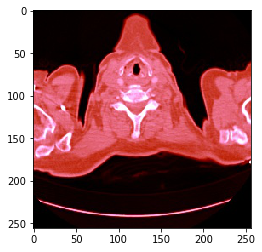

In [13]:
plt.imshow(img)

In [14]:
def plot_image(img):
    plt.figure(figsize=[12,6])
    plt.subplot(131)
    plt.imshow(img[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(img[:,:,2],cmap='gray')

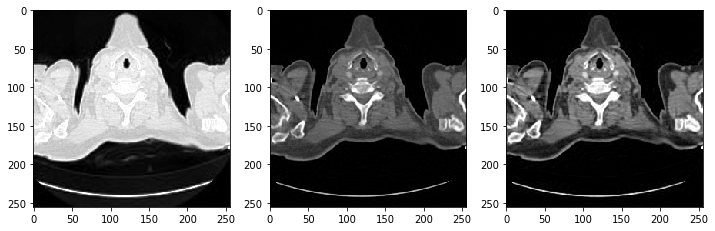

In [15]:
plot_image(np.array(img))

In [16]:
study_instances = df_train.StudyInstanceUID.unique()
len(study_instances)

7279

In [17]:
len(df_train.loc[df_train.StudyInstanceUID == study_instances[0]])

124

In [18]:
df_train.loc[df_train.StudyInstanceUID == study_instances[0]].sample(100)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
39,6897fa9de148,2bfbb7fd2e8b,148dfe893a66,0,0,0,0,0,0,1,1,0,0,1,0,0,0
74,6897fa9de148,2bfbb7fd2e8b,2ff8ee9ae8f9,0,0,0,0,0,0,1,1,0,0,1,0,0,0
25,6897fa9de148,2bfbb7fd2e8b,c6f29ac6659b,0,0,0,0,0,0,1,1,0,0,1,0,0,0
108,6897fa9de148,2bfbb7fd2e8b,031618cba689,1,0,0,0,0,0,1,1,0,0,1,0,0,0
7,6897fa9de148,2bfbb7fd2e8b,c6bbe08f2736,0,0,0,0,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,6897fa9de148,2bfbb7fd2e8b,b5e4babf2887,0,0,0,0,0,0,1,1,0,0,1,0,0,0
99,6897fa9de148,2bfbb7fd2e8b,559ac3d40184,1,0,0,0,0,0,1,1,0,0,1,0,0,0
58,6897fa9de148,2bfbb7fd2e8b,2a52ff46886c,0,0,0,0,0,0,1,1,0,0,1,0,0,0
82,6897fa9de148,2bfbb7fd2e8b,6e4ec3a3aea3,1,0,0,0,0,0,1,1,0,0,1,0,0,0


In [19]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.sample_size = 63 # min unique
        self.csv_file = csv_file
        self.study_instances = self.csv_file.StudyInstanceUID.unique()
        self.transform = transform

    def __len__(self):
        return len(df_train.StudyInstanceUID.unique())

    def __getitem__(self, idx):
        sub_df = self.csv_file.loc[self.csv_file.StudyInstanceUID == self.study_instances[idx]].sample(self.sample_size)
        imgs = []
        
        for i in range(len(sub_df)):
            img = get_an_image(sub_df, i)
            if self.transform:
                img = self.transform(img).to(device)
            imgs.append(img.unsqueeze(0))
            
        targets = torch.FloatTensor(sub_df.loc[sub_df.StudyInstanceUID == study_instances[idx]][image_level_features+exam_level_features+informational_features].values).to(device)
        
        return torch.cat(imgs, 0), targets

In [20]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
#                                 transforms.CenterCrop(224),
                                normalize
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [21]:
train_dataset = LungsDataset(df_train, transform=ds_trans)

len(train_dataset)

7279

In [22]:
df_train.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

In [23]:
resnet50 = models.resnet50()
fc_feat_size = resnet50.fc.in_features
resnet50.fc.in_features, resnet50.fc.out_features
# fc_feat_size = 2048
# resnet50.fc = nn.Linear(resnet50.fc.in_features, fc_feat_size)

(2048, 1000)

In [24]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def __forward__(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [25]:
resnet50.avgpool = Identity()
resnet50.fc = Identity()

In [26]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
image_level_features+exam_level_features+informational_features

['pe_present_on_image',
 'negative_exam_for_pe',
 'indeterminate',
 'chronic_pe',
 'acute_and_chronic_pe',
 'central_pe',
 'leftsided_pe',
 'rightsided_pe',
 'rv_lv_ratio_gte_1',
 'rv_lv_ratio_lt_1',
 'qa_motion',
 'qa_contrast',
 'true_filling_defect_not_pe',
 'flow_artifact']

In [28]:
fc_feat_size

2048

In [29]:
# fc_feat_size = 1024
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.weight)
        
class MultiTaskHead(nn.Module):
    def __init__(self):
        super(MultiTaskHead, self).__init__()
        self.m = nn.Sequential(
                nn.Conv2d(2048, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )
        self.l = nn.Sequential(
                nn.Linear(fc_feat_size, 1), 
                nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 2048, int(np.sqrt(x.shape[1]/2048)), int(np.sqrt(x.shape[1]/2048)))
        x = self.m(x)
        x = self.l(x.squeeze())
        return x

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        
        self.backbone = pretrained_model
        '''
        image-level feature
        '''
        self.linear_pe_present_on_image = MultiTaskHead()
        weights_init(self.linear_pe_present_on_image)
        '''
        exam-level features
        '''
        self.linear_negative_exam_for_pe = MultiTaskHead()
        weights_init(self.linear_negative_exam_for_pe)
        
        self.linear_indeterminate = MultiTaskHead()
        weights_init(self.linear_indeterminate)
        
        self.linear_chronic_pe = MultiTaskHead()
        weights_init(self.linear_chronic_pe)
        
        self.linear_acute_and_chronic_pe = MultiTaskHead()
        weights_init(self.linear_acute_and_chronic_pe)
        
        self.linear_central_pe = MultiTaskHead()
        weights_init(self.linear_central_pe)
        
        self.linear_leftsided_pe = MultiTaskHead()
        weights_init(self.linear_leftsided_pe)
        
        self.linear_rightsided_pe = MultiTaskHead()
        weights_init(self.linear_rightsided_pe)
        
        self.linear_rv_lv_ratio_gte_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_gte_1)
        
        self.linear_rv_lv_ratio_lt_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_lt_1)
        
        '''
        informational features
        '''
        self.linear_qa_motion = MultiTaskHead()
        weights_init(self.linear_qa_motion)
        
        self.linear_qa_contrast = MultiTaskHead()
        weights_init(self.linear_qa_contrast)
                
        self.linear_true_filling_defect_not_pe = MultiTaskHead()
        weights_init(self.linear_true_filling_defect_not_pe)
        
        self.linear_flow_artifact = MultiTaskHead()
        weights_init(self.linear_flow_artifact)

    def forward(self, x):
        x1 = self.backbone(x)
        
#         print('x1 .shape', x1.shape)
        x_pe_present_on_image = self.linear_pe_present_on_image(x1)
        
        x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x1)
        x_indeterminate = self.linear_indeterminate(x1)
        x_chronic_pe = self.linear_chronic_pe(x1)
        x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x1)
        x_central_pe = self.linear_central_pe(x1)
        x_leftsided_pe = self.linear_leftsided_pe(x1)
        x_rightsided_pe = self.linear_rightsided_pe(x1)
        x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x1)
        x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x1)
        
        x_qa_motion = self.linear_qa_motion(x1)
        x_qa_contrast = self.linear_qa_contrast(x1)
       
        x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x1)
        x_flow_artifact = self.linear_flow_artifact(x1)
        
        return x_pe_present_on_image, x_negative_exam_for_pe, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact 
                

model = WrapperModel(resnet50).to(device)

In [30]:
model

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [31]:
# df_train.loc[0][image_level_features+exam_level_features+informational_features]

In [32]:
for name, param in model.named_parameters():
    if not (name.startswith('backbone.layer4') or name.startswith('linear')):
        param.requires_grad = False

In [33]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [34]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [35]:
df_train.loc[df_train.negative_exam_for_pe == 1]['pe_present_on_image'].values.sum()

0

In [36]:
df_train.loc[df_train.indeterminate == 1][['qa_motion', 'qa_contrast']].values.sum()

43060

In [37]:
'''
Weights
'''
image_level_weights = [0.07361963]
exam_level_weights = [0.0736196319, 0.09202453988, 0.1042944785, 0.1042944785, 0.1877300613, 0.06257668712, 0.06257668712, 0.2346625767, 0.0782208589]

# Negative for PE	0.0736196319
# Indeterminate	0.09202453988
# Chronic	0.1042944785
# Acute & Chronic	0.1042944785
# Central PE	0.1877300613
# Left PE	0.06257668712
# Right PE	0.06257668712
# RV/LV Ratio >= 1	0.2346625767
# RV/LV Ratio < 1	0.0782208589



In [38]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [39]:
# image level log loss (for one exam/study)
def image_level_loss(y_pred, y_real):
#     q_i = (y_preds[0].squeeze() > 0.5).sum().item()/y_real.shape[0]
#     return image_level_weights[0]*q_i*F.binary_cross_entropy(y_preds[0].squeeze(), y_real[:,0])
#     print(y_pred[0].squeeze())
#     print(y_real[:,0])
    return criterion(y_pred[0].squeeze(), y_real[:,0])

In [40]:
def exam_level_loss(y_pred, y_real):
    total_loss = 0
#     for y_p, y_r, w in zip(y_preds[1:-4], y_real[:,1:-4].T, exam_level_weights):
#         loss = w*F.binary_cross_entropy(y_p.squeeze(), y_r)
#         total_loss += loss
    for y_p, y_r in zip(y_pred[1:-4], y_real[:,1:-4].T):
        loss = criterion(y_p.squeeze(), y_r)
        total_loss += loss
    return total_loss/y_real.shape[0]

In [41]:
def compute_loss(y_pred, y_real):
    im_loss = image_level_loss(y_pred, y_real)
    ex_loss = exam_level_loss(y_pred, y_real)
    return im_loss+ex_loss

In [42]:
import gc
gc.collect()

6931

In [43]:
def eval_on_sample(num_of_exams=8):
    losses = []
    for i in range(num_of_exams):
        rand_idx = np.random.randint(len(study_instances))
        X_eval, Y_eval = train_dataset[rand_idx]
        y_pred_eval = model(X_eval)
        loss_eval = compute_loss(y_pred_eval, Y_eval)
        losses.append(loss_eval)
    return losses


In [ ]:
# losses = eval_on_sample()

In [ ]:
# losses

In [44]:
gc.collect()

40

In [45]:
# model.load_state_dict(torch.load('./saved_resnet50'))
# model.eval()

In [ ]:
epochs = 30
steps_per_epoch = 500

model.train()
for epoch in range(epochs):  

#     running_loss = 0.0
    for i in range(steps_per_epoch):
#         try:
        rand_idx = np.random.randint(len(study_instances))
        X, Y = train_dataset[rand_idx]
#         print(X.shape)
        optimizer.zero_grad()
        y_preds = model(X)
#         print(y_preds[0].shape, Y.shape)
        loss = compute_loss(y_preds, Y)
        print('Loss:', loss.item())
        loss.backward()
        optimizer.step()
#         except:
        gc.collect()
#             print('AAAAAAAAAAAAA')

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Finished Training')

Loss: 0.7892138957977295
Loss: 0.7905004620552063
Loss: 0.791640043258667
Loss: 0.7911401391029358
Loss: 0.790287971496582
Loss: 0.7901816368103027
Loss: 0.7943044304847717
Loss: 0.797856330871582
Loss: 0.7975988984107971
Loss: 0.7936307787895203
Loss: 0.7895428538322449
Loss: 0.7893820405006409
Loss: 0.8008606433868408
Loss: 0.7921159863471985
Loss: 0.7888648509979248
Loss: 0.7886796593666077
Loss: 0.7923734188079834
Loss: 0.7887507081031799
Loss: 0.7881172895431519
Loss: 0.7879299521446228
Loss: 0.7877290844917297
Loss: 0.789409875869751
Loss: 0.7873044013977051
Loss: 0.7870810031890869
Loss: 0.7868465185165405
Loss: 0.7866020798683167
Loss: 0.7863485217094421
Loss: 0.7860866785049438
Loss: 0.7961915135383606
Loss: 0.7855778336524963
Loss: 0.7853286266326904
Loss: 0.787408173084259
Loss: 0.7819312810897827
Loss: 0.7933616638183594
Loss: 0.7843731641769409
Loss: 0.7841432094573975
Loss: 0.7903449535369873
Loss: 0.793363094329834
Loss: 0.7887507081031799
Loss: 0.7831677198410034
Loss: 

In [ ]:
# torch.save(model, './saved_resnet50')
torch.save(model.state_dict(), './saved_resnet50')

In [ ]:
model.eval()

In [ ]:
import gc
gc.collect()


# # del X
# del Y
# del y_preds

torch.cuda.empty_cache()

In [ ]:
losses = eval_on_sample()

In [ ]:
losses

In [ ]:
def reshape_pred(pred_y):
    ys = []
    for y in pred_y:
        ys.append(y)
    return torch.cat(ys, 1)

In [ ]:
rand_idx = np.random.randint(len(study_instances))
print(rand_idx)
X, Y = train_dataset[rand_idx]
y_pred_eval = model(X)

In [ ]:
Y

In [ ]:
y_pred = reshape_pred(y_pred_eval)

In [ ]:
(y_pred >= 0.5).type(torch.FloatTensor)

In [ ]:
y_pred